<a href="https://colab.research.google.com/github/shekharp77/neural_networks/blob/main/shekhar_singh_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/cdata/data/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/cdata/data/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Load train and validation datasets
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load test dataset
test_ds = image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Extract class names
class_names = train_ds.class_names
print("Class names in the dataset:", class_names)

# Verify the resizing
for image, label in train_ds.take(1):
    print(f"Image shape: {image.shape}")

Found 17739 files belonging to 9 classes.
Using 14192 files for training.
Found 17739 files belonging to 9 classes.
Using 3547 files for validation.
Found 118 files belonging to 9 classes.
Class names in the dataset: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Image shape: (32, 180, 180, 3)


In [7]:
class_names = train_ds.class_names
print("Class names in the dataset:", class_names)

Class names in the dataset: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
!pip install tensorflow-addons

Data Agumantation

In [9]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# Efficiently get the number of images in each dataset
train_image_count = len(list(data_dir_train.glob('*/*.jpg')))
val_image_count = int(train_image_count * 0.2)
train_image_count = train_image_count - val_image_count
test_image_count = len(list(data_dir_test.glob('*/*.jpg')))

print(f"Number of training images: {train_image_count}")
print(f"Number of validation images: {val_image_count}")
print(f"Number of test images: {test_image_count}")

Number of training images: 1792
Number of validation images: 447
Number of test images: 118


# Visualising data

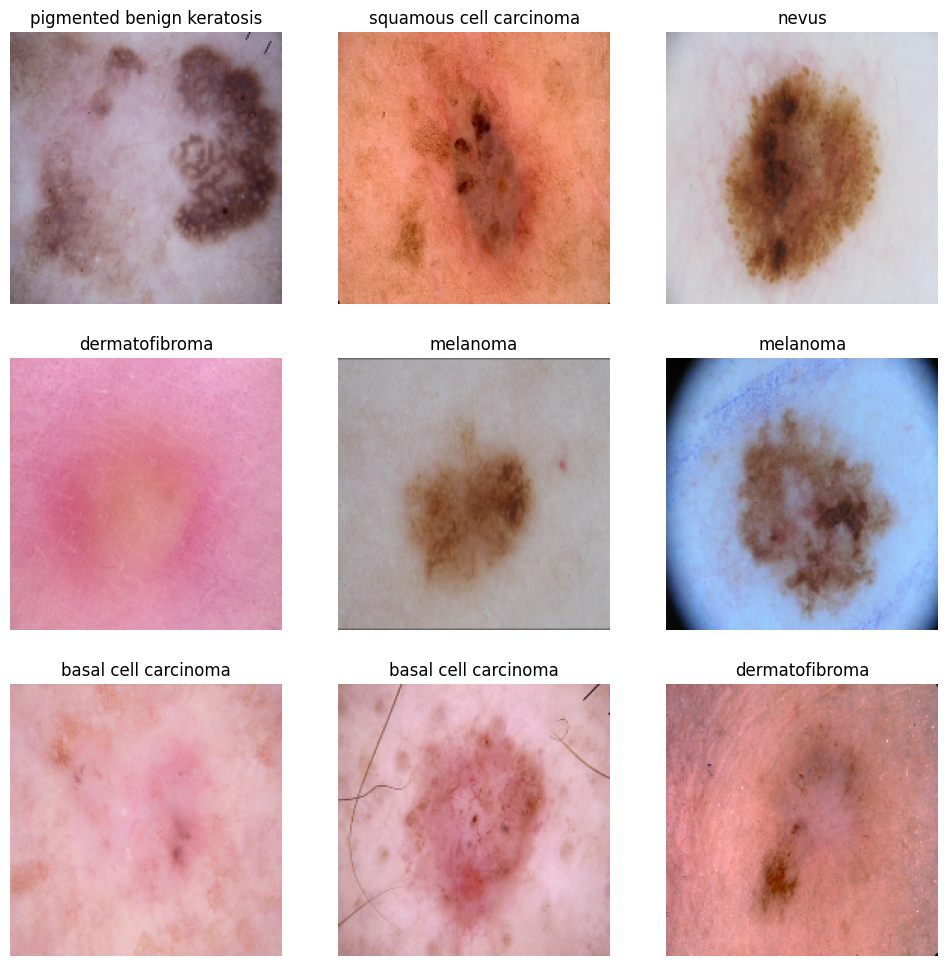

In [11]:
# Visualize test data
def visualize_test_data(dataset, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()

visualize_test_data(test_ds, class_names)

# Model Building


Model config 1

Building a model with more complex values

In [12]:
# Enhanced CNN model with Batch Normalization and Dropout
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 178, 178, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 176, 176, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 64)        0         
 D)                                                              
                                                        

In [13]:
# Define early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=22,
    callbacks=[early_stopping]
)

Epoch 1/22
56/56 [==============================] - 334s 6s/step - loss: 2.6059 - accuracy: 0.2991 - val_loss: 2.2235 - val_accuracy: 0.1991
Epoch 2/22
56/56 [==============================] - 20s 349ms/step - loss: 2.0815 - accuracy: 0.3890 - val_loss: 2.1870 - val_accuracy: 0.2908
Epoch 3/22
56/56 [==============================] - 20s 359ms/step - loss: 1.9162 - accuracy: 0.4286 - val_loss: 2.0207 - val_accuracy: 0.3311
Epoch 4/22
56/56 [==============================] - 19s 345ms/step - loss: 1.7381 - accuracy: 0.4749 - val_loss: 1.9741 - val_accuracy: 0.3870
Epoch 5/22
56/56 [==============================] - 19s 344ms/step - loss: 1.6128 - accuracy: 0.5045 - val_loss: 1.6611 - val_accuracy: 0.4653
Epoch 6/22
56/56 [==============================] - 19s 340ms/step - loss: 1.6053 - accuracy: 0.5056 - val_loss: 1.7686 - val_accuracy: 0.4586
Epoch 7/22
56/56 [==============================] - 20s 351ms/step - loss: 1.3852 - accuracy: 0.5480 - val_loss: 1.6806 - val_accuracy: 0.4653
E

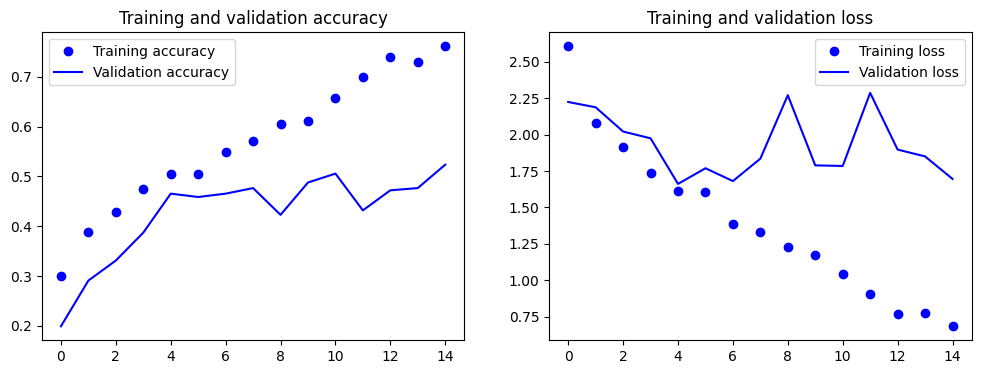

4/4 [==============================] - 8s 882ms/step - loss: 2.5233 - accuracy: 0.2712
Test Accuracy: 0.27
Test Loss: 2.52


In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

Model config 2

Building a model with more simpler value

In [22]:
from tensorflow.keras import layers, models, callbacks

# Simplified CNN model with Batch Normalization and lower learning rate
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_16 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_17 (Ba  (None, 87, 87, 64)       

In [16]:
# Define early stopping with adjusted patience
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
56/56 [==============================] - 10s 99ms/step - loss: 3.1551 - accuracy: 0.1752 - val_loss: 2.4861 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 85ms/step - loss: 2.6025 - accuracy: 0.2584 - val_loss: 2.2015 - val_accuracy: 0.1834
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 2.3413 - accuracy: 0.3047 - val_loss: 2.1276 - val_accuracy: 0.2349
Epoch 4/20
56/56 [==============================] - 5s 86ms/step - loss: 2.2792 - accuracy: 0.3538 - val_loss: 2.0523 - val_accuracy: 0.3177
Epoch 5/20
56/56 [==============================] - 5s 85ms/step - loss: 2.1107 - accuracy: 0.3683 - val_loss: 1.9478 - val_accuracy: 0.3624
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9944 - accuracy: 0.4057 - val_loss: 1.8568 - val_accuracy: 0.3982
Epoch 7/20
56/56 [==============================] - 5s 85ms/step - loss: 1.8943 - accuracy: 0.4196 - val_loss: 1.8381 - val_accuracy: 0.4072
Epoch 8/20
5

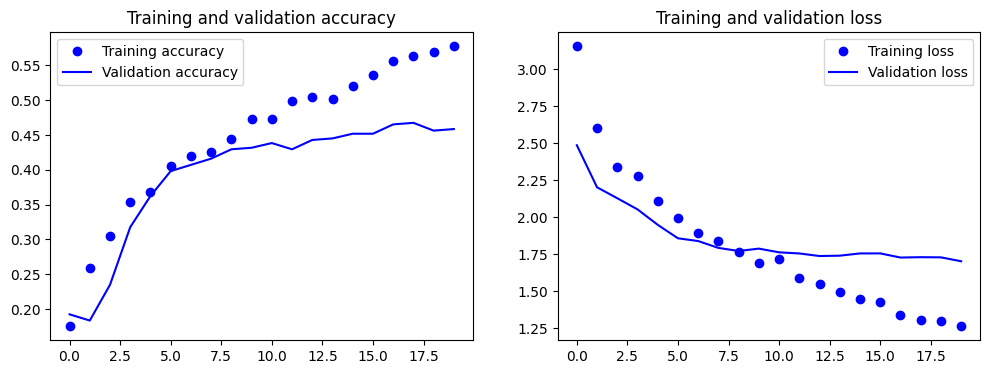

4/4 [==============================] - 0s 147ms/step - loss: 2.1440 - accuracy: 0.2881
Test Accuracy: 0.29
Test Loss: 2.14


In [17]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

Model config 3

The simpler values did not worked much so now going with more complex values

In [23]:
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Enhanced CNN model with Batch Normalization and Dropout
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(9, activation='softmax')
])

# Compile the model with learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization_20 (Ba  (None, 178, 178, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 176, 176, 64)      36928     
                                                                 
 batch_normalization_21 (Ba  (None, 176, 176, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 88, 88, 64)        0         
 g2D)                                                            
                                                      

In [19]:
# Define early stopping with adjusted patience
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
56/56 [==============================] - 24s 348ms/step - loss: 3.8111 - accuracy: 0.3242 - val_loss: 3.9929 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 19s 342ms/step - loss: 3.2083 - accuracy: 0.4420 - val_loss: 3.7079 - val_accuracy: 0.1521
Epoch 3/20
56/56 [==============================] - 19s 346ms/step - loss: 3.0637 - accuracy: 0.4788 - val_loss: 3.5555 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 20s 350ms/step - loss: 2.9339 - accuracy: 0.5201 - val_loss: 3.2269 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 20s 351ms/step - loss: 2.8011 - accuracy: 0.5463 - val_loss: 3.0470 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 19s 348ms/step - loss: 2.7133 - accuracy: 0.5731 - val_loss: 3.0301 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 19s 343ms/step - loss: 2.5936 - accuracy: 0.6044 - val_loss: 3.2631 - val_accuracy: 0.4474

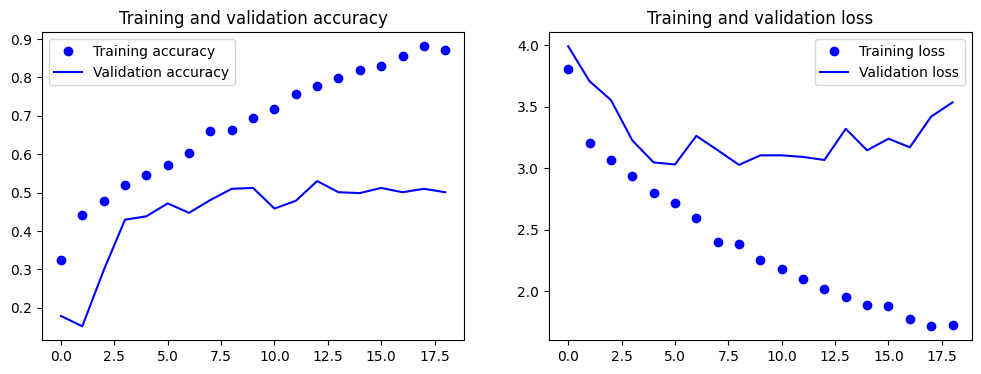

4/4 [==============================] - 0s 65ms/step - loss: 3.8643 - accuracy: 0.3814
Test Accuracy: 0.38
Test Loss: 3.86


In [20]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

Still the accuracy can be improved

In [13]:
!pip install Augmentor

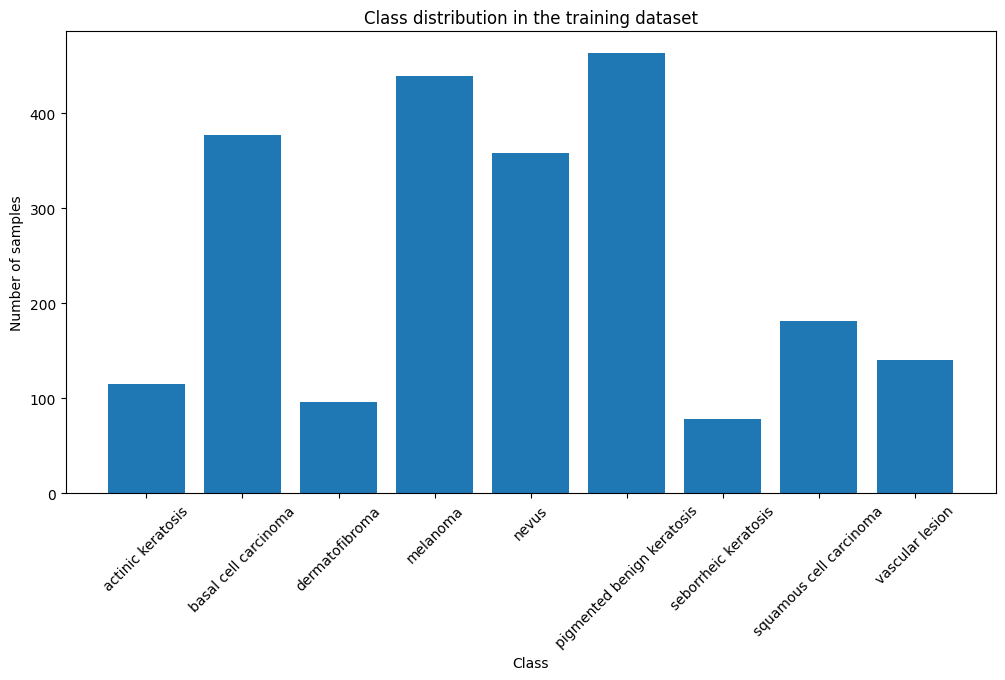

In [14]:
import os
import matplotlib.pyplot as plt

# Define paths to training dataset
path_to_training_dataset = "/content/gdrive/My Drive/cdata/data/Train/"

# Count number of samples per class
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(path_to_training_dataset, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution in the training dataset')
plt.xticks(rotation=45)
plt.show()

In [16]:
import Augmentor
import os


# Apply augmentation and generate samples
for class_name in class_names:
    print(os.path.join(path_to_training_dataset, class_name))
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, class_name.lower()))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(100)  # Add 500 samples per class to balance the dataset

/content/gdrive/My Drive/cdata/data/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CD0ADA09960>: 100%|██████████| 100/100 [00:05<00:00, 18.13 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD0B42740D0>: 100%|██████████| 100/100 [00:04<00:00, 20.50 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD0B4255360>: 100%|██████████| 100/100 [00:05<00:00, 18.00 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CD0B42778E0>: 100%|██████████| 100/100 [00:26<00:00,  3.76 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7CD0ADC27370>: 100%|██████████| 100/100 [00:20<00:00,  5.00 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD0ADC27370>: 100%|██████████| 100/100 [00:06<00:00, 16.12 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CD0AEE53070>: 100%|██████████| 100/100 [00:07<00:00, 13.15 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD0ADBA4EE0>: 100%|██████████| 100/100 [00:06<00:00, 14.96 Samples/s]


/content/gdrive/My Drive/cdata/data/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CD0B4256BC0>: 100%|██████████| 100/100 [00:04<00:00, 23.64 Samples/s]


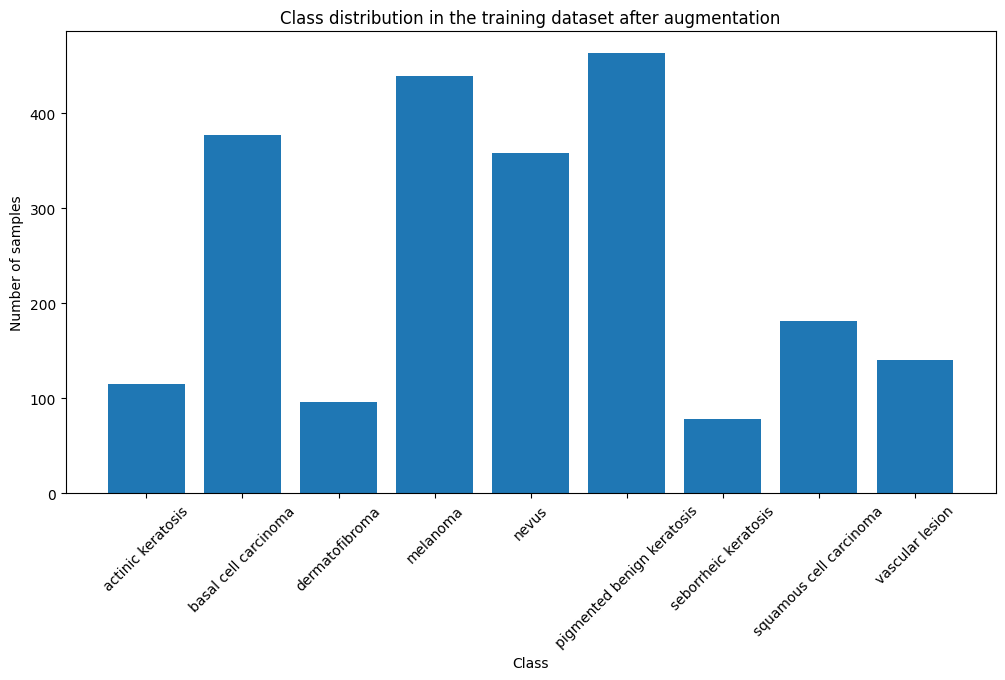

In [17]:
# Count number of samples per class after augmentation
class_counts_augmented = {}
for class_name in class_names:
    class_dir = os.path.join(path_to_training_dataset, class_name.lower())
    class_counts_augmented[class_name] = len(os.listdir(class_dir))

# Plot class distribution after augmentation
plt.figure(figsize=(12, 6))
plt.bar(class_counts_augmented.keys(), class_counts_augmented.values())
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution in the training dataset after augmentation')
plt.xticks(rotation=45)
plt.show()

Further improving class imbalance

In [18]:
# Underrepresented classes
underrepresented_classes = ["Actinic keratosis", "Dermatofibroma", "Seborrheic keratosis", "Vascular lesion"]

# Apply augmentation and generate samples for underrepresented classes
for class_name in underrepresented_classes:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, class_name.lower()))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(100)  # Add 100 samples per class to balance the dataset

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD0AEE52230>: 100%|██████████| 100/100 [00:05<00:00, 17.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CD0ADB1FF40>: 100%|██████████| 100/100 [00:04<00:00, 22.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CD0B42548E0>: 100%|██████████| 100/100 [00:10<00:00,  9.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/cdata/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD0B4232860>: 100%|██████████| 100/100 [00:04<00:00, 24.41 Samples/s]


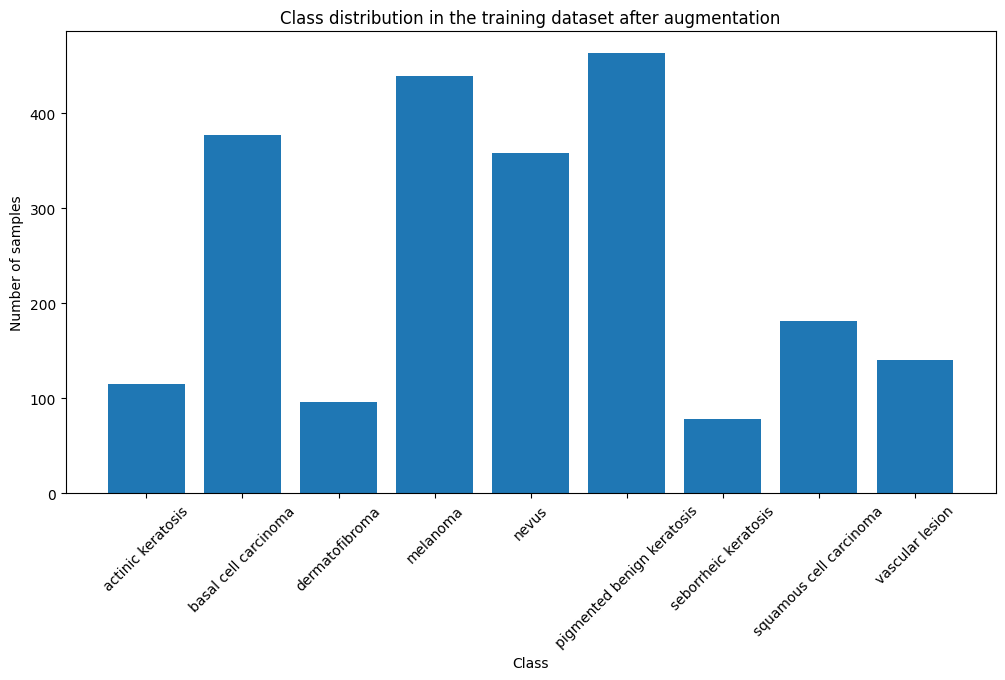

In [19]:
# Count number of samples per class after augmentation
class_counts_augmented = {}
for class_name in class_names:
    class_dir = os.path.join(path_to_training_dataset, class_name.lower())
    class_counts_augmented[class_name] = len(os.listdir(class_dir))

# Plot class distribution after augmentation
plt.figure(figsize=(12, 6))
plt.bar(class_counts_augmented.keys(), class_counts_augmented.values())
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution in the training dataset after augmentation')
plt.xticks(rotation=45)
plt.show()

Partitioning new data

In [28]:
# Reload the data with augmented samples
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Prefetch data for performance optimization
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 17739 files belonging to 9 classes.
Using 14192 files for training.
Found 17739 files belonging to 9 classes.
Using 3547 files for validation.
Found 118 files belonging to 9 classes.


A simplified version of complex model

In [20]:
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Simplified CNN model with Batch Normalization and Dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(9, activation='softmax')
])

# Compile the model with learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_9 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
# Define early stopping with adjusted patience
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Reduced number of epochs
    callbacks=[early_stopping]
)

Epoch 1/10
  3/444 [..............................] - ETA: 2:57:40 - loss: 4.6878 - accuracy: 0.1354